In [1]:
import os
import json
import csv
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2 as cv
from utils_orb import *
import random
random.seed(100)
from tqdm import tqdm

## Create the list of instances

In [2]:
with open(os.path.join(data_path, "2DInstances.txt")) as f:
            reader = csv.reader(f, delimiter='\t')
            next(reader)
            instances = [i for i in reader]

In [3]:
nb_instances = len(instances)
print(f"Number of instances: {nb_instances}")

Number of instances: 1129


## Example: parsing and loading one instance

In [4]:
my_instance = instances[100]

In [5]:
parse_instance(my_instance)

{'reference': '5104a9c7-adc4-2a85-9026-45557dcf9a87',
 'scan': '5104a9c7-adc4-2a85-9026-45557dcf9a87',
 'frame_nr': 797,
 'instance_id': 12,
 'label': 'sofa',
 'bbox': [329, 0, 780, 539],
 'visibility': [40536.0, 62231.0, 0.65138, 162150.0, 171327.0, 0.946436],
 'number_other_instances': 4,
 'other_instance_ids': [46, 47, 48, 49],
 'other_bboxes': [[304, 283, 487, 526],
  [370, 77, 509, 304],
  [274, 165, 448, 447],
  [271, 430, 453, 539]]}

In [6]:
my_loaded_instance = load_instance(my_instance, transform)
my_loaded_instance

{'image': <PIL.Image.Image image mode=RGB size=224x224 at 0x7F0C33FD7F70>,
 'bbox': {'x': 48, 'y': 76, 'w': 127, 'h': 106},
 'label': 'sofa',
 'instance_id': 12,
 'reference': '5104a9c7-adc4-2a85-9026-45557dcf9a87',
 'scan': '5104a9c7-adc4-2a85-9026-45557dcf9a87',
 'frame_nr': 797}

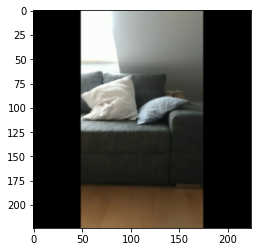

In [7]:
plt.imshow(my_loaded_instance["image"])
plt.show()

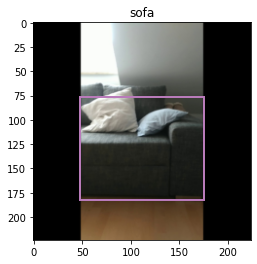

In [8]:
fig, ax = plt.subplots(1)
plt.title(my_loaded_instance["label"])
ax.imshow(my_loaded_instance["image"])
bbox = my_loaded_instance["bbox"]
x = bbox["x"]
y = bbox["y"]
width = bbox["w"]
height = bbox["h"]
rect = patches.Rectangle((x, y), width, height,
                         linewidth=2, edgecolor=np.random.rand(3,), facecolor='none')
ax.add_patch(rect)
plt.show()

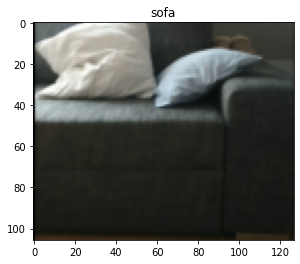

In [9]:
image_crop = my_loaded_instance["image"].crop((x, y, x+width, y+height))
plt.title(my_loaded_instance["label"])
plt.imshow(image_crop)
plt.show()

## ORB

In [10]:
crop = False

In [11]:
detector = cv.ORB.create()

In [12]:
ref_inst = []
for i in range(len(instances)):
    my_instance = parse_instance(instances[i])
    key = my_instance["reference"] + "-" + str(my_instance["instance_id"])
    if key not in ref_inst:
        ref_inst.append(key)

In [13]:
print(f"Number of unique instances: {len(ref_inst)}")

Number of unique instances: 48


In [14]:
# Organize data by key (reference + instance_id)
data_dict = {}
for i in ref_inst:
    data_dict[i] = []

for idx in range(len(instances)):
    my_instance = parse_instance(instances[idx])
    key = my_instance["reference"] + "-" + str(my_instance["instance_id"])
    data_dict[key].append(idx)

In [15]:
for key in data_dict:
    random.shuffle(data_dict[key])

In [16]:
def partitionRankings(rawRatings, testPercent):
    howManyNumbers = int(round(testPercent*len(rawRatings)))
    shuffled = rawRatings[:]
    random.shuffle(shuffled)
    return shuffled[howManyNumbers:], shuffled[:howManyNumbers]

In [17]:
L = list(range(10))
L1, L2 = partitionRankings(L, 0.2)

In [18]:
L1, L2

([0, 5, 9, 1, 4, 8, 7, 2], [3, 6])

In [19]:
pourcentage_train = 0.1
train_dict = {i: [] for i in ref_inst}
test_dict = {i: [] for i in ref_inst}

for i in data_dict:
    L = data_dict[i]
    test_dict[i], train_dict[i] = partitionRankings(L, pourcentage_train)

In [20]:
len(test_dict[ref_inst[0]]) + len(train_dict[ref_inst[0]]) == len(data_dict[ref_inst[0]])

True

In [21]:
def get_label_img(idx):
    my_loaded_instance = load_instance(instances[idx], transform)
    reference = my_loaded_instance["reference"]
    label = my_loaded_instance["label"]
    img = my_loaded_instance["image"]
    bbox = my_loaded_instance["bbox"]
    x = bbox["x"]
    y = bbox["y"]
    width = bbox["w"]
    height = bbox["h"]
    if crop:
        cropped_img = img.crop((x, y, x+width, y+height))
    else:
        cropped_img = img
    return reference, label, cropped_img

In [22]:
# Training
train_labels = {}
train_refs = {}
train_descriptors = {}
train_kps = {}
#detector = cv.ORB.create()
for k, v in tqdm(train_dict.items()):
    for i in range(len(v)):
        ref, label, cropped_img = get_label_img(v[i])
        cropped_img_cv = np.asarray(cropped_img)[:,:,::-1].copy()
        cropped_img_cv = cv.cvtColor(cropped_img_cv, cv.COLOR_BGR2GRAY)
        kp, des = detector.detectAndCompute(cropped_img_cv, None)
        train_descriptors[v[i]] = des
        train_kps[v[i]] = kp
        train_labels[v[i]] = label
        train_refs[v[i]] = ref

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.75it/s]


In [23]:
# Test
test_labels = {}
test_refs = {}
test_descriptors = {}
test_kps = {}
#detector = cv.ORB.create()
for k, v in tqdm(test_dict.items()):
    for i in range(len(v)):
        ref, label, cropped_img = get_label_img(v[i])
        cropped_img_cv = np.asarray(cropped_img)[:,:,::-1].copy()
        cropped_img_cv = cv.cvtColor(cropped_img_cv, cv.COLOR_BGR2GRAY)
        kp, des = detector.detectAndCompute(cropped_img_cv, None)
        test_descriptors[v[i]] = des
        test_kps[v[i]] = kp
        test_labels[v[i]] = label
        test_refs[v[i]] = ref

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [01:18<00:00,  1.63s/it]


In [24]:
query_idx = test_dict[ref_inst[1]][0]
query_idx

99

In [25]:
load_instance(instances[query_idx])

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=960x540 at 0x7F0C305A9640>,
 'bbox': {'x': 363, 'y': 0, 'w': 409, 'h': 539},
 'label': 'sofa',
 'instance_id': 12,
 'reference': '5104a9c7-adc4-2a85-9026-45557dcf9a87',
 'scan': '5104a9c7-adc4-2a85-9026-45557dcf9a87',
 'frame_nr': 796}

In [26]:
query_instance = load_instance(instances[query_idx], transform)

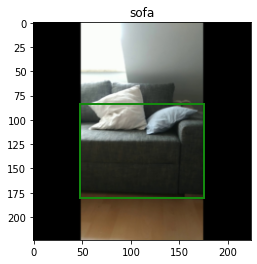

In [27]:
fig, ax = plt.subplots(1)
plt.title(query_instance["label"])
ax.imshow(query_instance["image"])
bbox = query_instance["bbox"]
x = bbox["x"]
y = bbox["y"]
width = bbox["w"]
height = bbox["h"]
rect = patches.Rectangle((x, y), width, height,
                         linewidth=2, edgecolor=np.random.rand(3,), facecolor='none')
ax.add_patch(rect)
plt.show()

In [28]:
len(test_kps[query_idx])

346

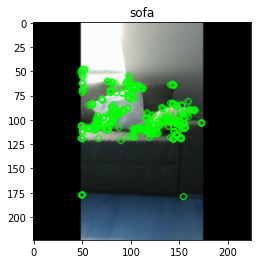

In [29]:
query_ref, query_label, query_img = get_label_img(query_idx)
query_img_cv = np.asarray(query_img)[:,:,::-1].copy()
img2 = cv.drawKeypoints(query_img_cv, test_kps[query_idx], None, color=(0,255,0), flags=0)
plt.imshow(img2)
plt.title(query_label)
plt.show()

In [30]:
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
matches_dict = {}
for idx in train_descriptors:
    matches = bf.match(train_descriptors[idx], test_descriptors[query_idx])
    matches = sorted(matches, key=lambda x: x.distance)
    matches_dict[idx] = matches
        
avg_distances = {k: np.mean([i.distance for i in v]) for k, v in matches_dict.items()}
avg_distances = sorted(avg_distances, key=avg_distances.get)

In [31]:
nearest_matches = avg_distances[:5]
nearest_matches

[522, 650, 1102, 506, 628]

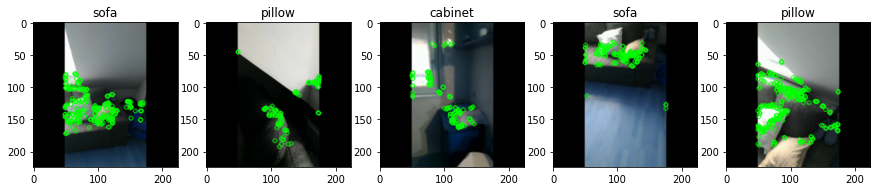

In [32]:
fig, axs = plt.subplots(1, 5, figsize=(15,15))

for idx, match in enumerate(nearest_matches):
    result_ref, result_label, result_img = get_label_img(match)
    result_img_cv = np.asarray(result_img)[:,:,::-1].copy()
    #cropped_result_img_cv = cv.cvtColor(cropped_result_img_cv, cv.COLOR_BGR2GRAY)
    img2 = cv.drawKeypoints(result_img_cv, train_kps[match], None, color=(0,255,0), flags=0)
    axs[idx].imshow(img2)
    axs[idx].title.set_text(result_label)
plt.show()

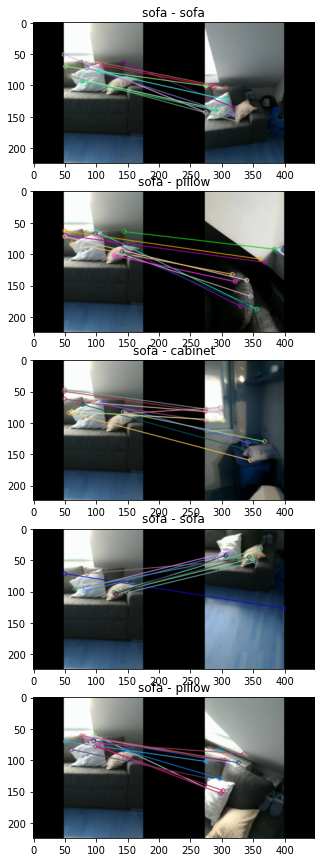

In [33]:
fig, axs = plt.subplots(5, 1, figsize=(15,15))

for idx, match in enumerate(nearest_matches):
    result_ref, result_label, result_img = get_label_img(match)
    result_img_cv = np.asarray(result_img)[:,:,::-1].copy()
    #cropped_result_img_cv = cv.cvtColor(cropped_result_img_cv, cv.COLOR_BGR2GRAY)
    matches = bf.match(test_descriptors[query_idx], train_descriptors[match])
    img2 = cv.drawMatches(query_img_cv, test_kps[query_idx], result_img_cv, 
                          train_kps[match], matches[:10], None,
                          flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    axs[idx].imshow(img2)
    axs[idx].title.set_text(query_label + " - " + result_label)
plt.show()

In [34]:
print(len(train_descriptors))

109


In [35]:
del_train = []
for k, v in train_descriptors.items():
    if v is None:
        del_train.append(k)
        
for k in del_train:
        del train_descriptors[k]

In [36]:
print(len(train_descriptors))

109


In [37]:
print(len(test_descriptors))

1020


In [38]:
del_test = []
for k, v in test_descriptors.items():
    if v is None:
        del_test.append(k)
        
for k in del_test:
        del test_descriptors[k]

In [39]:
print(len(test_descriptors))

1020


In [40]:
def reid_score(k):
    score_class = 0
    score_obj = 0
    score_room = 0
    for i in tqdm(test_descriptors.keys()):
        bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
        matches_dict = {}
        for j in train_descriptors:
            matches = bf.match(train_descriptors[j], test_descriptors[i])
            matches = sorted(matches, key=lambda x: x.distance)
            matches_dict[j] = matches

        avg_distances = {k: np.mean([i.distance for i in v]) for k, v in matches_dict.items()}
        avg_distances = sorted(avg_distances, key=avg_distances.get)
        nearest_matches = avg_distances[:k]
        
        class_add = 0
        obj_add = 0
        room_add = 0
        for l in nearest_matches:
            if test_labels[i] == train_labels[l] and test_refs[i] == train_refs[l]:
                class_add = 1
                obj_add = 1
                room_add = 1
                break
            elif test_labels[i] == train_labels[l]:
                class_add = 1
            elif test_refs[i] == train_refs[l]:
                room_add = 1
        score_class += class_add
        score_obj += obj_add
        score_room += room_add
        
    score_class /= len(test_descriptors)  
    score_obj /= len(test_descriptors)
    score_room /= len(test_descriptors)
    
    return score_obj, score_class, score_room

In [42]:
for i in [1, 2, 5, 10, 20, 50]:
    print(f"Rank {i} matching score: {reid_score(i)}")

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1020/1020 [04:12<00:00,  4.03it/s]


Rank 1 matching score: (0.6068627450980392, 0.6245098039215686, 0.7490196078431373)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1020/1020 [05:09<00:00,  3.29it/s]


Rank 2 matching score: (0.6745098039215687, 0.6990196078431372, 0.8568627450980392)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1020/1020 [06:15<00:00,  2.71it/s]


Rank 5 matching score: (0.7676470588235295, 0.8176470588235294, 0.9147058823529411)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1020/1020 [06:25<00:00,  2.65it/s]


Rank 10 matching score: (0.8274509803921568, 0.8941176470588236, 0.961764705882353)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1020/1020 [05:39<00:00,  3.01it/s]


Rank 20 matching score: (0.8872549019607843, 0.9392156862745098, 0.9921568627450981)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1020/1020 [06:03<00:00,  2.81it/s]


Rank 50 matching score: (0.9343137254901961, 0.9735294117647059, 1.0)


## Results

**Cropped dataset**

<table><tr><th> Rank <th><th> 1 <th><th> 5 <th><th> 20 <th><tr>
<tr><td> Object re-id (10% Training Data) <td><td> 49.80% <td><td>69.49% <td><td> 84.70% <td><tr>
<tr><td> Class re-id (10% Training Data) <td><td> 51.76% <td><td>76.14% <td><td> 88.92% <td><tr>
<tr><td> Reference re-id (10% Training Data) <td><td> 71.84% <td><td>89.05% <td><td> 99.22% <td><tr>
<table>
    
**Uncropped dataset**

<table><tr><th> Rank <th><th> 1 <th><th> 5 <th><th> 20 <th><tr>
<tr><td> Object re-id (10% Training Data) <td><td> 63.14% <td><td>75.39% <td><td> 87.54% <td><tr>
<tr><td> Class re-id (10% Training Data) <td><td> 64.41% <td><td>81.86% <td><td> 93.43% <td><tr>
<tr><td> Reference re-id (10% Training Data) <td><td> 76.37% <td><td>90.39% <td><td> 99.02% <td><tr>
<table>

**Remarques :**
* Résultats sans cropping meilleurs
* Plus rapide avec cropping

**A considérer :**
* Plus de données
* Score avec mAP
* Re-ranking pour améliorer le score